<a href="https://colab.research.google.com/github/NSR9/Extensive-Vision-AI/blob/main/Assignment_5/Notebook_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NoteBook 2:-
##Target:

* Added a conv layer to the lower end of the model
* Added image augumentations on the model

## Results: (to Change)
* Parameters: **13.8k**
* Best Train Accuracy: **99.21**
* Best Test Accuracy: **99.45 (9th Epoch), 99.48 (20th Epoch)**

## Analysis: (Pending)
* 
* 

## Calling out to the GODS (Importing Libs):

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

## Network Block :

#### Conv Block 1
* 2D Convolution number of kernels 8, followed with Batch Normalization and 2D Dropout of 0.1 
* 2D Convolution number of kernels 16, followed with Batch Normalization and 2D Dropout of 0.1
* 2D Convolution number of kernels 32, followed with Batch Normalization and 2D Dropout of 0.1

#### Transition Layer 1
* 2D Max Pooling to reduce the size of the channel to 14
* 2d Convolution with kernel size 1 reducing the number of channels to 8

#### Conv Block 2
* 2D Convolution number of kernels 16, followed with Batch Normalization and 2D Dropout of 0.1 
* 2D Convolution number of kernels 16, followed with Batch Normalization and 2D Dropout of 0.1
* 2D Convolution number of kernels 16, followed with Batch Normalization and 2D Dropout of 0.1

#### Transition Layer 2
* 2D Max Pooling to reduce the size of the channel to 7

#### Conv Block 3
* 2D Convolution number of kernels 16, followed with Batch Normalization and 2D Dropout of 0.1 
* 2D Convolution number of kernels 10 (Avoid Batch Normalization and Dropout in Last layer before GAP)

#### Global Average Pooling
* Global Average pooling with a size 3 and no Padding to return a 10 x 1 x 1 as the value to go to log_softmax 

In [38]:
dropout_value = 0.02
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_block1 = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, bias=False), #28, 28
              nn.ReLU(),
              nn.BatchNorm2d(8),
              nn.Dropout(dropout_value),

              nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0, bias=False), #28, 26
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.Dropout(dropout_value),

              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0, bias=False), #26, 24
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.Dropout(dropout_value)
        )


        self.trans1 = nn.Sequential(
              nn.MaxPool2d(2, 2),#24, 12
              nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False) #12, 12
        )

        self.conv_block2 = nn.Sequential(
              nn.Conv2d(in_channels=8, out_channels=10, kernel_size=3, padding=0, bias=False),#12, 10
              nn.ReLU(),
              nn.BatchNorm2d(10),
              nn.Dropout(dropout_value),

              nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding=0, bias=False),#10, 8
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.Dropout(dropout_value),

              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0, bias=False),#8, 6
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.Dropout(dropout_value),
        )

        self.gap = nn.Sequential(
              nn.AvgPool2d(kernel_size=6, stride=1, padding = 0),#4, 1
        ) 

        self.conv_block3 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),#1, 1
              nn.ReLU(),
              nn.BatchNorm2d(16),
              nn.Dropout(dropout_value),

              nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),#1, 1
        )

    def forward(self, x):

        x =  self.conv_block1(x)
        x =  self.trans1(x)
        x =  self.conv_block2(x)
        x =  self.gap(x)
        x =  self.conv_block3(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(x)

##Model Summary:

#### Params used 15,970

In [39]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 26, 26]           1,152
              ReLU-6           [-1, 16, 26, 26]               0
       BatchNorm2d-7           [-1, 16, 26, 26]              32
           Dropout-8           [-1, 16, 26, 26]               0
            Conv2d-9           [-1, 16, 24, 24]           2,304
             ReLU-10           [-1, 16, 24, 24]               0
      BatchNorm2d-11           [-1, 16, 24, 24]              32
          Dropout-12           [-1, 16, 24, 24]               0
        MaxPool2d-13           [-1, 16, 12, 12]               0
           Conv2d-14            [-1, 8,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [40]:
model.eval()

Net(
  (conv_block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.02, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.02, inplace=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): ReLU()
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.02, inplace=False)
  )
  (trans1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
   

In [41]:
train_transforms =  transforms.Compose(
    [
    #  transforms.RandomAffine(10, fill=(1,)),
     transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
     transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
     transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))
    ]
)

# We Don't apply transformations on the Test Data

## Loading DataSet:


In [42]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=train_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

## Train Test Functions:

In [43]:
from tqdm import tqdm
conf_matrix = torch.zeros((10,10))
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'epoch={epoch} loss={loss.item():.10f} batch_id={batch_idx:05d}')
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100.00*correct/len(train_loader.dataset)
    return train_acc, train_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            conf_matrix[target][target.view_as(pred)] += 1

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = 100.00 * correct / len(test_loader.dataset)
    return test_acc, test_loss


## Model Training:

In [44]:
from torch.optim.lr_scheduler import StepLR
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []

# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(1, 16):
    train_acc, train_loss = train(model, device, train_loader, optimizer, epoch)
    test_acc, test_loss = test(model, device, test_loader)

    train_accuracy_values.append(train_acc)
    train_loss_values.append(train_loss)

    test_accuracy_values.append(test_acc)
    test_loss_values.append(test_loss)

    


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0689, Accuracy: 9805/10000 (98.05%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9873/10000 (98.73%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9894/10000 (98.94%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9875/10000 (98.75%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9911/10000 (99.11%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9909/10000 (99.09%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9922/10000 (99.22%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9916/10000 (99.16%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9927/10000 (99.27%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9931/10000 (99.31%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9936/10000 (99.36%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9918/10000 (99.18%)



epoch=15 loss=0.0094937580 batch_id=00468: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s]



Test set: Average loss: 0.0222, Accuracy: 9939/10000 (99.39%)



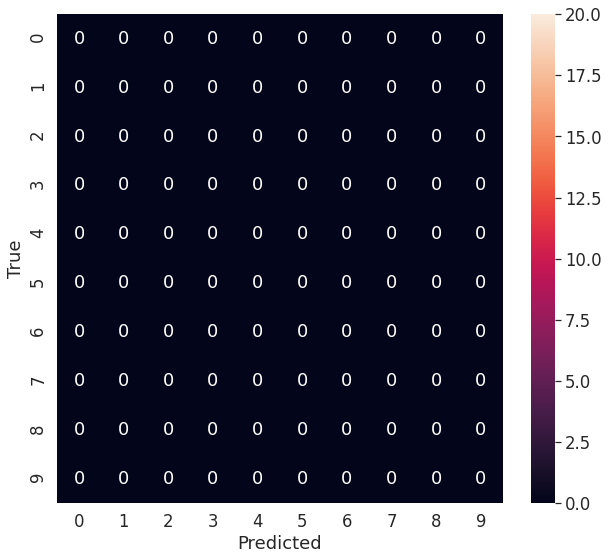

In [29]:
# Confussion Matrix
import seaborn as sns
plt.subplots(figsize=(10,9))
ax = sns.heatmap(conf_matrix, annot=True, vmax=20)
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

# Need to correct this too

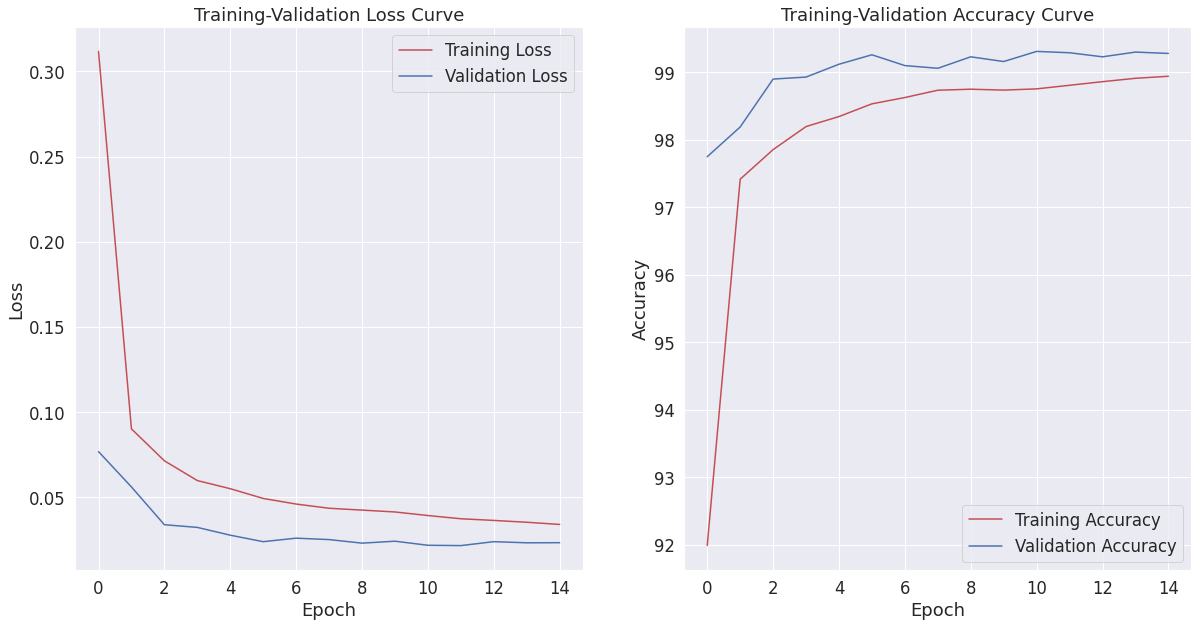

In [30]:
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(np.array(train_loss_values), 'r', label="Training Loss")
plt1.plot(np.array(test_loss_values), 'b', label="Validation Loss")
plt2.plot(np.array(train_accuracy_values), 'r', label="Training Accuracy")
plt2.plot(np.array(test_accuracy_values), 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


79


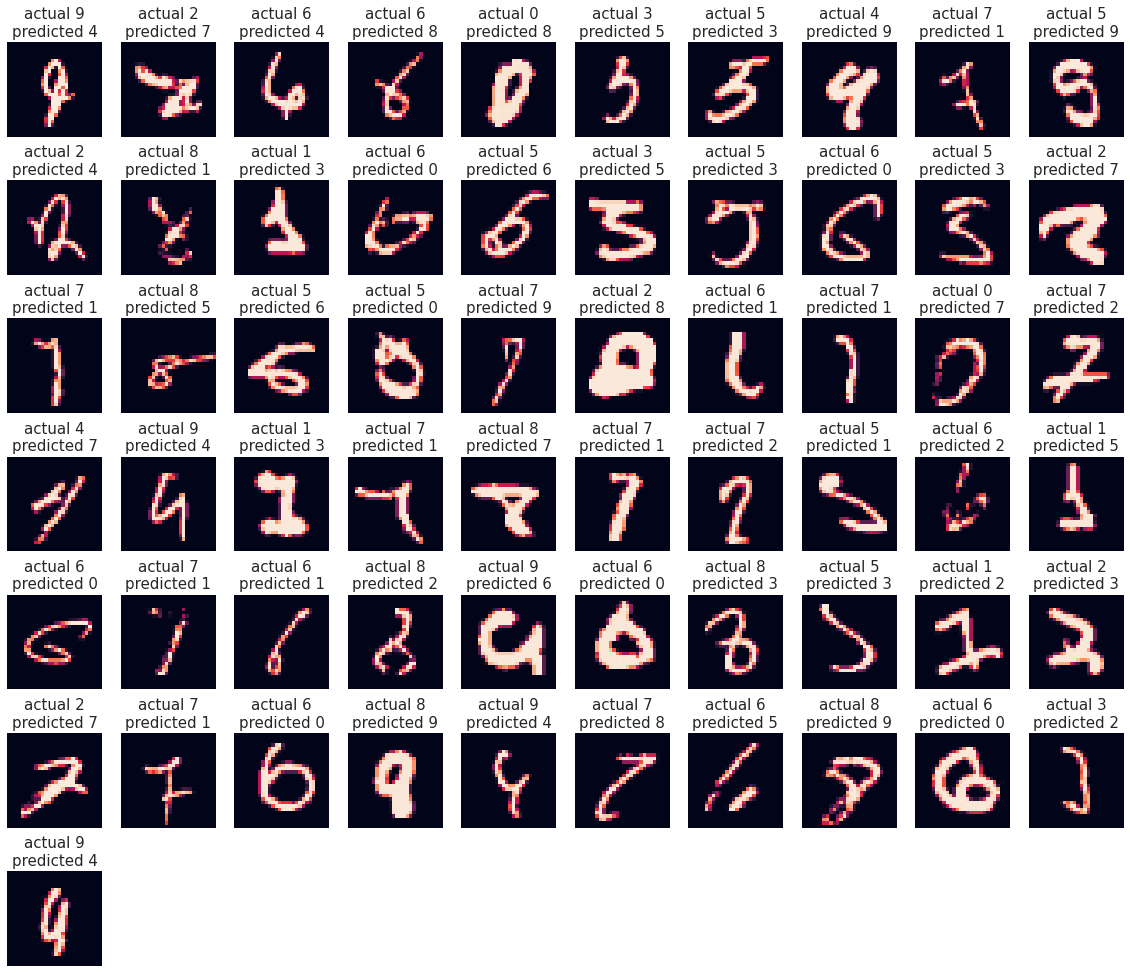

In [45]:
wrong_images=[]
wrong_label=[]
correct_label=[]
fig = plt.figure(figsize=(20,25))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        wrong_pred = pred.eq(target.view_as(pred)) == False
        wrong_images.append(data[wrong_pred])
        wrong_label.append(pred[wrong_pred])
        correct_label.append(target.view_as(pred)[wrong_pred])   

print(len(wrong_images))

for i, (img, pred, correct) in enumerate(zip(torch.cat(wrong_images),torch.cat(wrong_label), torch.cat(correct_label))):
    img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())